In [3]:
#Needed Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
import re

import os
import sys

from tqdm import tqdm

import json
from pathlib import Path

import matplotlib.pyplot as plt

# from links.data import LinkData

# import cv2

print("Starting Notebook.")

sns.set(font_scale = 1.25)
sns.set_style("whitegrid")

Starting Notebook.


In [4]:
SOURCES = ['Apache', 'Hyperledger', 'IntelDAOS', 
           'JFrog', 'Jira', 'JiraEcosystem', 
           'MariaDB', 'MongoDB', 'Qt', 
           'RedHat', 'Sakai', 'SecondLife', 
           'Sonatype', 'Spring']
#Mindville
CONFIG = ['R_LTvNL', 'R_LTvOL', 'R_LTvNLOL', 'R_LTOLvNL']
LT = 'Duplication'

## Loading Data

In [5]:
def print_linktypes(SOURCE):
    #Loading Issues
    filename = '../data/crawl/issues_'+SOURCE.lower()+'.csv'
    issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=';')
    
    issue_set = set(issues['issue_id'])
        
    #Loading Links
    filename = '../data/crawl/clean_links_'+SOURCE.lower()+'.csv'
    links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0)

    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    num_dups = len(links[links['linktype']=='Duplicate'])
        
    return len(issues), len(links), len(links.linktype.unique()), round(len(link_set)/len(issue_set), 3), num_dups

In [6]:
overview = pd.DataFrame(columns = ['Project', '#Issues', '#Links', '#Linktypes', '%IssuesWithLinks', '#NumDups'])
j=0
for s in SOURCES:
    i, l, ltu, pi, nd = print_linktypes(s)
    
    if s == 'JiraEcosystem':
        s = 'JiraEco.'
    
    overview.loc[j]=[s, i, l, ltu, pi, nd]
    
    j+=1

In [7]:
overview.sort_values(by=['#Issues'], ascending=False)

,Project,#Issues,#Links,#Linktypes,%IssuesWithLinks,#NumDups
0,Apache,970929,242823,21,0.283,24868
9,RedHat,315797,106200,18,0.389,5436
4,Jira,265343,98122,19,0.477,21350
8,Qt,140237,35855,8,0.289,3827
7,MongoDB,90629,37545,13,0.426,6548
12,Sonatype,77837,4289,11,0.075,337
13,Spring,69100,14461,9,0.256,1744
10,Sakai,49204,19057,7,0.422,1807
5,JiraEco.,40602,10911,18,0.328,1721
6,MariaDB,31229,14618,8,0.445,1374


## Loading Model Results

In [8]:
R_LTvNL_df = pd.DataFrame(columns = ['Project', 'LT_pre','LT_rec', 'LT_f1',
                                     'OL_pre', 'OL_rec', 'OL_f1', 
                                     'NL_pre', 'NL_rec', 'NL_f1',
#                                      'Both_pre', 'Both_rec', 'Both_f1',
                                     'macrco_pre', 'macro_rec', 'macro_f1',
                                     'Acc', 'Auc'])
R_LTvOL_df = pd.DataFrame(columns = ['Project', 'LT_pre','LT_rec', 'LT_f1',
                                     'OL_pre', 'OL_rec', 'OL_f1', 
                                     'NL_pre', 'NL_rec', 'NL_f1',
#                                      'Both_pre', 'Both_rec', 'Both_f1',
                                     'macrco_pre', 'macro_rec', 'macro_f1',
                                     'Acc', 'Auc'])
R_LTvNLOL_df = pd.DataFrame(columns = ['Project', 'LT_pre','LT_rec', 'LT_f1',
                                     'OL_pre', 'OL_rec', 'OL_f1', 
                                     'NL_pre', 'NL_rec', 'NL_f1',
#                                      'Both_pre', 'Both_rec', 'Both_f1',
                                     'macrco_pre', 'macro_rec', 'macro_f1',
                                     'Acc', 'Auc'])
R_LTOLvNL_df = pd.DataFrame(columns = ['Project', 'LT_pre','LT_rec', 'LT_f1',
                                     'OL_pre', 'OL_rec', 'OL_f1', 
                                     'NL_pre', 'NL_rec', 'NL_f1',
#                                      'Both_pre', 'Both_rec', 'Both_f1',
                                     'macrco_pre', 'macro_rec', 'macro_f1',
                                     'Acc', 'Auc'])

In [9]:
big_dict = {
    'R_LTvNL': R_LTvNL_df, 
    'R_LTvOL': R_LTvOL_df, 
    'R_LTvNLOL': R_LTvNLOL_df,  
    'R_LTOLvNL': R_LTOLvNL_df  
}

In [10]:
# SOURCES = ['qt', 'jira', 'jiraecosystem', 'mariadb', 'apache', 'mongodb']

valid_projects = []

for s in SOURCES:
    valid = True
    for c in CONFIG:
        filename = 'results/dccnn_latenight_'+s.lower()+'_'+LT+'_'+c+'_metrics.csv'
        metrics_df = pd.read_csv(filename, encoding="UTF-8", low_memory=False)
        
        LT_mets = metrics_df.iloc[0].values.tolist()[1:]
        NL_mets = metrics_df.iloc[1].values.tolist()[1:]
        OL_mets = metrics_df.iloc[2].values.tolist()[1:]
#         Both_mets = metrics_df.iloc[3].values.tolist()[1:]
        macro_pre = metrics_df['Precision'].iloc[0:3].sum()/3
        macro_rec = metrics_df['Recall'].iloc[0:3].sum()/3
        macro_f1 = metrics_df['F1'].iloc[0:3].sum()/3
        macro_mets = [macro_pre, macro_rec, macro_f1]
        
        filename = 'results/dccnn_latenight_'+s.lower()+'_'+LT+'_'+c+'_accauc.csv'
        accauc_df = pd.read_csv(filename, encoding="UTF-8", low_memory=False)
        
        accauc = accauc_df.iloc[0].values.tolist()[1:]
        
#         filename = 'results/'+s+'_'+LT+'_'+c+'_confmat.csv'
#         confmat = pd.read_csv(filename, encoding="UTF-8", low_memory=False)
    
        temp_df = big_dict[c]
        
        if s == 'JiraEcosystem':
            temp_row = ['JiraEco.'] + LT_mets + OL_mets + NL_mets + macro_mets + accauc
        else:
            temp_row = [s] + LT_mets + OL_mets + NL_mets + macro_mets + accauc
        
        valid = valid and not(np.isnan(LT_mets + OL_mets + NL_mets).any())
          
        temp_df.loc[len(temp_df)] = temp_row
    if valid:
        if s == 'JiraEcosystem':
            valid_projects.append('JiraEco.')
        else:
            valid_projects.append(s)

In [12]:
valid_projects

['Apache',
 'Hyperledger',
 'Jira',
 'JiraEco.',
 'MariaDB',
 'MongoDB',
 'Qt',
 'RedHat',
 'Sakai',
 'Spring']

# Figures

In [13]:
temp_df1 = R_LTvNL_df[['Project', 'macro_f1']]
temp_df1['dataset'] = 'DvNL'
temp_df2 = R_LTvOL_df[['Project', 'macro_f1']]
temp_df2['dataset'] = 'DvOL'
temp_df3 = R_LTvNLOL_df[['Project', 'macro_f1']]
temp_df3['dataset'] = 'DvNLOL'
temp_df4 = R_LTOLvNL_df[['Project', 'macro_f1']]
temp_df4['dataset'] = 'DOLvNL'

<ipython-input-13-9ab82b36f127>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df1['dataset'] = 'DvNL'
<ipython-input-13-9ab82b36f127>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df2['dataset'] = 'DvOL'
<ipython-input-13-9ab82b36f127>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [14]:
frames = [temp_df1, temp_df2, temp_df3, temp_df4]

tidy_df = pd.concat(frames, sort=False)

In [15]:
project_order = overview.sort_values(by=['#Links'], ascending=False)['Project'].values.tolist()

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

project_list = intersection(project_order, valid_projects)
print(project_order)
print(valid_projects)

print()
print(project_list)

['Apache', 'RedHat', 'Jira', 'MongoDB', 'Qt', 'Sakai', 'Hyperledger', 'MariaDB', 'Spring', 'JiraEco.', 'Sonatype', 'IntelDAOS', 'JFrog', 'SecondLife']
['Apache', 'Hyperledger', 'Jira', 'JiraEco.', 'MariaDB', 'MongoDB', 'Qt', 'RedHat', 'Sakai', 'Spring']

['Apache', 'RedHat', 'Jira', 'MongoDB', 'Qt', 'Sakai', 'Hyperledger', 'MariaDB', 'Spring', 'JiraEco.']


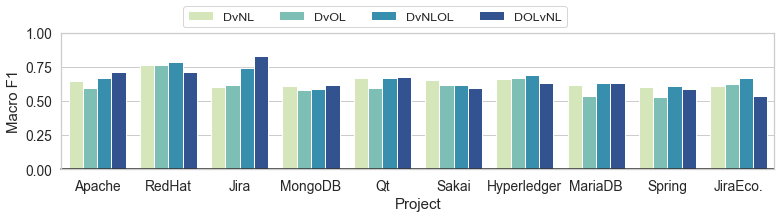

In [23]:
f, ax = plt.subplots(1, 1, figsize=(11, 3), sharex=True)

fig = plt.gcf()
# fig.set_size_inches(12, 5)

# plt.xticks(rotation=90)
ax = sns.barplot(x='Project', y='macro_f1', hue ='dataset', data=tidy_df, order=project_list, ax=ax, palette="YlGnBu")
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("Macro F1")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(-0.275, 1.05, 1, 0), ncol=4, fontsize='small')

ax.legend([],[], frameon=False)

ax.set(ylim=(0, 1))
fig.tight_layout()        

fig.savefig('results/DCCNN_f1.png', dpi = 300, bbox_inches='tight')


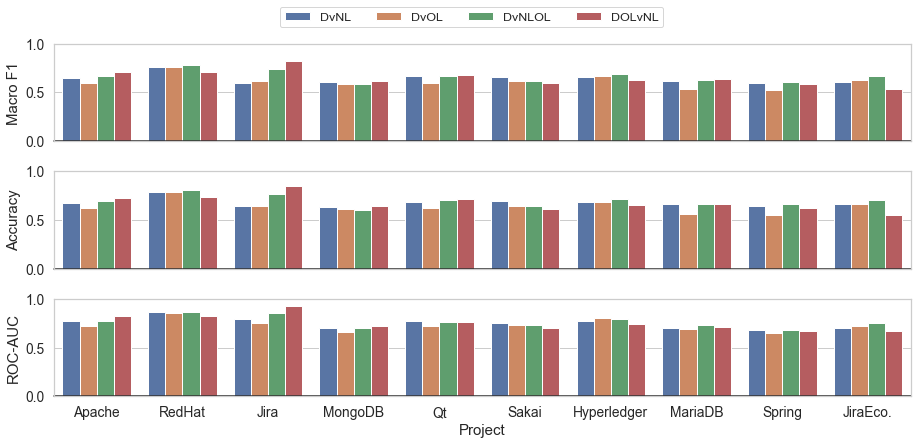

In [36]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 6), sharex=True)

fig = plt.gcf()
# fig.set_size_inches(12, 5)

# plt.xticks(rotation=90)
ax1 = sns.barplot(x='Project', y='macro_f1', hue ='dataset', data=tidy_df, order=project_list, ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Macro F1")

ax1.legend([],[], frameon=False)
ax1.set(xlabel=None)

ax2 = sns.barplot(x='Project', y='Acc', hue ='dataset', data=tidy_df, order=project_list, ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Accuracy")
# ax2._legend.remove()

ax2.legend([],[], frameon=False)
ax2.set(xlabel=None)

ax3 = sns.barplot(x='Project', y='Auc', hue ='dataset', data=tidy_df, order=project_list, ax=ax3)
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("ROC-AUC")

handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(-0.275, 1.05, 1, 0), ncol=4, fontsize='small')

ax3.legend([],[], frameon=False)

ax1.set(ylim=(0, 1))
ax2.set(ylim=(0, 1))
ax3.set(ylim=(0, 1))

fig.tight_layout()        

fig.savefig('results/DCCNN_all.png', dpi = 300, bbox_inches='tight')



# Statistical Significances

In [18]:
temp1 = big_dict['R_LTvNL']
temp2 = big_dict['R_LTvNLOL']

temp1 = temp1[temp1['Project'].isin(valid_projects)]
temp2 = temp2[temp2['Project'].isin(valid_projects)]

acc1 = temp1["Acc"]
acc2 = temp2["Acc"]

auc1 = temp1["Auc"]
auc2 = temp2["Auc"]

mf1 = temp1["macro_f1"]
mf2 = temp2["macro_f1"]

mp1 = temp1["macrco_pre"]
mp2 = temp2["macrco_pre"]

mr1 = temp1["macro_rec"]
mr2 = temp2["macro_rec"]

In [19]:
print(temp1.describe())
print(temp2.describe())

          LT_pre     LT_rec      LT_f1     OL_pre     OL_rec      OL_f1  \
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean    0.513453   0.697622   0.588730   0.650522   0.557898   0.591612   
std     0.050690   0.110162   0.062476   0.068163   0.135036   0.105017   
min     0.468238   0.535248   0.512500   0.587601   0.227348   0.327889   
25%     0.485964   0.601715   0.543050   0.589810   0.527172   0.566801   
50%     0.500201   0.728869   0.595802   0.633330   0.583688   0.619040   
75%     0.521125   0.770997   0.617228   0.702567   0.649043   0.644206   
max     0.642117   0.840607   0.718328   0.780855   0.681462   0.714743   

          NL_pre     NL_rec      NL_f1  macrco_pre  macro_rec   macro_f1  \
count  10.000000  10.000000  10.000000   10.000000  10.000000  10.000000   
mean    0.724849   0.777788   0.748710    0.629608   0.677769   0.643017   
std     0.078283   0.066868   0.064573    0.056737   0.043457   0.049675   
min     0.622081   0

In [20]:
from scipy import stats

print(stats.ttest_ind(acc1, acc2, equal_var=False))
print(stats.ttest_ind(auc1, auc2, equal_var=False))
print(stats.ttest_ind(mf1, mf2, equal_var=False))

print(stats.ttest_ind(mp1, mp2, equal_var=False))
print(stats.ttest_ind(mr1, mr2, equal_var=False))

Ttest_indResult(statistic=-0.8818894763540458, pvalue=0.39047519536363795)
Ttest_indResult(statistic=-0.43668417049770775, pvalue=0.6675705635282003)
Ttest_indResult(statistic=-0.9465258514371545, pvalue=0.35695002572165624)
Ttest_indResult(statistic=-0.6578999384566564, pvalue=0.5189617186375384)
Ttest_indResult(statistic=-0.882357500484712, pvalue=0.3902292638488867)


In [21]:
mcnemar = pd.read_csv('results/mcnemar_latenight_dccnn.csv')
print(mcnemar)

       Unnamed: 0       p-value
0          apache  2.501954e-13
1          redhat  3.160170e-52
2            jira  4.272355e-78
3         mongodb  2.851364e-04
4              qt  5.630124e-02
5           sakai  1.368522e-01
6     hyperledger  1.510603e-02
7         mariadb  9.555586e-01
8          spring  3.633066e-02
9   jiraecosystem  2.051594e-14
10       sonatype           NaN
11          jfrog           NaN
12      inteldaos           NaN
13     secondlife           NaN
14      mindville           NaN


# Values for Tables

In [22]:
def add_mean(df):
    
    og_df = df[df['Project'].isin(valid_projects)]
    
    averages = og_df.mean()
    avg_row = averages.to_list()
    avg_row.insert(0, "Mean")
    
    stds = og_df.std()
    std_row = stds.to_list()
    std_row.insert(0, "Standard Dev.")
    
    df.loc[len(df)] = avg_row
    df.loc[len(df)] = std_row
    
    return df

In [23]:
add_mean(big_dict['R_LTvNL'])

,Project,LT_pre,LT_rec,LT_f1,OL_pre,OL_rec,OL_f1,NL_pre,NL_rec,NL_f1,macrco_pre,macro_rec,macro_f1,Acc,Auc
0,Apache,0.507955,0.766362,0.610958,0.665016,0.464545,0.546991,0.772376,0.792371,0.782246,0.648449,0.674426,0.646732,0.674555,0.770542
1,Hyperledger,0.516717,0.769231,0.618182,0.715084,0.579186,0.640000,0.752427,0.701357,0.725995,0.661409,0.683258,0.661392,0.683258,0.775348
2,IntelDAOS,0.000000,0.000000,NaN,0.500000,1.000000,0.666667,0.500000,1.000000,0.666667,0.333333,0.666667,0.444444,0.666667,0.819509
3,JFrog,0.000000,0.000000,NaN,0.500000,1.000000,0.666667,0.500000,1.000000,0.666667,0.333333,0.666667,0.444444,0.666667,0.716971
4,Jira,0.484083,0.840607,0.614368,0.587856,0.227348,0.327889,0.846169,0.876766,0.861196,0.639370,0.648241,0.601151,0.648241,0.790565
5,JiraEco.,0.491607,0.535248,0.512500,0.594533,0.681462,0.635036,0.622081,0.765013,0.686183,0.569407,0.660574,0.611240,0.660574,0.698219
6,MariaDB,0.492447,0.592727,0.537954,0.588235,0.581818,0.585009,0.664671,0.807273,0.729064,0.581784,0.660606,0.617342,0.660606,0.703881
7,MongoDB,0.468238,0.691377,0.558338,0.622921,0.509834,0.560732,0.695522,0.704992,0.700225,0.595560,0.635401,0.606432,0.635401,0.702962
8,Qt,0.522594,0.771586,0.623138,0.719383,0.585557,0.645608,0.756485,0.709576,0.732280,0.666154,0.688906,0.667009,0.688906,0.771615
9,RedHat,0.642117,0.815067,0.718328,0.780855,0.658952,0.714743,0.827440,0.886771,0.856079,0.750137,0.786930,0.763050,0.786930,0.867805


In [24]:
add_mean(big_dict['R_LTvOL'])

,Project,LT_pre,LT_rec,LT_f1,OL_pre,OL_rec,OL_f1,NL_pre,NL_rec,NL_f1,macrco_pre,macro_rec,macro_f1,Acc,Auc
0,Apache,0.459688,0.762045,0.573452,0.737073,0.668108,0.700898,0.647029,0.435968,0.520932,0.614596,0.622040,0.598427,0.621984,0.724129
1,Hyperledger,0.518310,0.832579,0.638889,0.802139,0.678733,0.735294,0.765823,0.547511,0.638522,0.695424,0.686275,0.670902,0.686275,0.802727
2,IntelDAOS,0.000000,0.000000,NaN,0.500000,1.000000,0.666667,0.500000,1.000000,0.666667,0.333333,0.666667,0.444444,0.666667,0.823959
3,JFrog,0.000000,0.000000,NaN,0.500000,1.000000,0.666667,0.498099,0.992424,0.663291,0.332700,0.664141,0.443319,0.664141,0.707415
4,Jira,0.477540,0.784289,0.593630,0.776966,0.751455,0.763997,0.644155,0.390482,0.486221,0.632887,0.642075,0.614616,0.642075,0.748116
5,JiraEco.,0.500000,0.631854,0.558247,0.682432,0.791123,0.732769,0.610497,0.577023,0.593289,0.597643,0.666667,0.628101,0.666667,0.726230
6,MariaDB,0.416667,0.818182,0.552147,0.739583,0.516364,0.608137,0.650350,0.338182,0.444976,0.602200,0.557576,0.535087,0.557576,0.687240
7,MongoDB,0.444444,0.620272,0.517840,0.638589,0.670953,0.654371,0.593193,0.553707,0.572770,0.558742,0.614977,0.581660,0.614977,0.663495
8,Qt,0.461538,0.767661,0.576481,0.753539,0.710361,0.731313,0.629073,0.394035,0.484556,0.614717,0.624019,0.597450,0.624019,0.722745
9,RedHat,0.667135,0.754028,0.707925,0.765317,0.802133,0.783293,0.769607,0.821647,0.794776,0.734020,0.792603,0.761998,0.792603,0.851353


In [25]:
add_mean(big_dict['R_LTvNLOL'])

,Project,LT_pre,LT_rec,LT_f1,OL_pre,OL_rec,OL_f1,NL_pre,NL_rec,NL_f1,macrco_pre,macro_rec,macro_f1,Acc,Auc
0,Apache,0.534501,0.716975,0.612435,0.701240,0.665341,0.682819,0.715056,0.709872,0.712455,0.650265,0.697396,0.669236,0.697415,0.770027
1,Hyperledger,0.549342,0.755656,0.636190,0.742857,0.705882,0.723898,0.733990,0.674208,0.702830,0.675396,0.711916,0.687640,0.711916,0.789327
2,IntelDAOS,0.000000,0.000000,NaN,0.500000,1.000000,0.666667,0.500000,1.000000,0.666667,0.333333,0.666667,0.444444,0.666667,0.783909
3,JFrog,1.000000,0.022727,0.044444,0.505747,1.000000,0.671756,0.505747,1.000000,0.671756,0.670498,0.674242,0.462652,0.674242,0.729654
4,Jira,0.617246,0.789900,0.692981,0.776080,0.728180,0.751367,0.788228,0.782003,0.785103,0.727184,0.766694,0.743150,0.766694,0.852687
5,JiraEco.,0.548387,0.665796,0.601415,0.700234,0.780679,0.738272,0.667532,0.671018,0.669271,0.638718,0.705831,0.669653,0.705831,0.751348
6,MariaDB,0.502924,0.625455,0.557536,0.647260,0.687273,0.666667,0.649660,0.694545,0.671353,0.599948,0.669091,0.631852,0.669091,0.731736
7,MongoDB,0.444754,0.724660,0.551208,0.659176,0.532526,0.589121,0.671480,0.562784,0.612346,0.591803,0.606657,0.584225,0.606657,0.698254
8,Qt,0.540590,0.689953,0.606207,0.706973,0.748038,0.726926,0.682220,0.665620,0.673818,0.643261,0.701204,0.668984,0.701204,0.761542
9,RedHat,0.696429,0.778761,0.735297,0.780850,0.788291,0.784553,0.797676,0.872249,0.833297,0.758318,0.813100,0.784382,0.813100,0.868241


In [26]:
add_mean(big_dict['R_LTOLvNL'])

,Project,LT_pre,LT_rec,LT_f1,OL_pre,OL_rec,OL_f1,NL_pre,NL_rec,NL_f1,macrco_pre,macro_rec,macro_f1,Acc,Auc
0,Apache,0.777141,0.702124,0.737730,0.773636,0.689208,0.728986,0.567853,0.798757,0.663798,0.706210,0.730030,0.710171,0.730063,0.828602
1,Hyperledger,0.743316,0.628959,0.681373,0.712575,0.538462,0.613402,0.484594,0.782805,0.598616,0.646828,0.650075,0.631130,0.650075,0.741733
2,IntelDAOS,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.333333,1.000000,0.500000,0.111111,0.333333,0.166667,0.333333,0.696689
3,JFrog,0.000000,0.000000,NaN,1.000000,0.280303,0.437870,0.367688,1.000000,0.537678,0.455896,0.426768,0.325183,0.426768,0.730343
4,Jira,0.853788,0.800914,0.826507,0.863974,0.871155,0.867550,0.724607,0.862843,0.787706,0.814123,0.844971,0.827254,0.844971,0.929273
5,JiraEco.,0.682403,0.415144,0.516234,0.697959,0.446475,0.544586,0.414765,0.806789,0.547872,0.598376,0.556136,0.536231,0.556136,0.667872
6,MariaDB,0.645390,0.661818,0.653501,0.661017,0.709091,0.684211,0.502874,0.636364,0.561798,0.603094,0.669091,0.633170,0.669091,0.716304
7,MongoDB,0.667745,0.624811,0.645565,0.666125,0.620272,0.642382,0.477213,0.689107,0.563912,0.603694,0.644730,0.617286,0.644730,0.721116
8,Qt,0.663860,0.742543,0.701000,0.678308,0.792779,0.731089,0.573180,0.624019,0.597520,0.638449,0.719780,0.676536,0.719780,0.765682
9,RedHat,0.780012,0.853642,0.815168,0.715244,0.604720,0.655355,0.583639,0.759247,0.659961,0.692965,0.739203,0.710161,0.739203,0.824376


In [27]:
R_LTvNL_avg_df = pd.DataFrame(columns = ['Precision','Recall', 'F1'])
R_LTvOL_avg_df = pd.DataFrame(columns = ['Precision','Recall', 'F1'])
R_LTvNLOL_avg_df = pd.DataFrame(columns = ['Precision','Recall', 'F1'])
R_LTOLvNL_avg_df = pd.DataFrame(columns = ['Precision','Recall', 'F1'])

In [28]:
big_dict_2 = {
    'R_LTvNL': R_LTvNL_avg_df, 
    'R_LTvOL': R_LTvOL_avg_df, 
    'R_LTvNLOL': R_LTvNLOL_avg_df,  
    'R_LTOLvNL': R_LTOLvNL_avg_df  
}

In [29]:
for c in CONFIG:
    results_df = big_dict[c]
    temp_df = big_dict_2[c]
    
    mean = results_df[results_df['Project']=='Mean']
    x = mean.iloc[0].values.tolist()

    temp_df.loc[len(temp_df)] = x[1:4]
    temp_df.loc[len(temp_df)] = x[4:7]
    temp_df.loc[len(temp_df)] = x[7:10]
    
#     print(temp_df.mean())
    
    temp_df.loc[len(temp_df)] = temp_df.mean()

    temp_df.rename(index={0: LT, 1: 'Other-Link' , 2: 'Non-Link', 3: 'Macro avg'}, inplace=True)

In [30]:
def get_latex_print(df):
    
    blub = df
    
    blub['Precision'] = blub['Precision'].apply(lambda x: round(x,2))
    blub['Recall'] = blub['Recall'].apply(lambda x: round(x,2))
    blub['F1'] = blub['F1'].apply(lambda x: round(x,2))
        
    print(blub.to_latex(index=False))  

In [31]:
get_latex_print(R_LTvNL_avg_df)

\begin{tabular}{rrr}
\toprule
 Precision &  Recall &   F1 \\
\midrule
      0.51 &    0.70 & 0.59 \\
      0.65 &    0.56 & 0.59 \\
      0.72 &    0.78 & 0.75 \\
      0.63 &    0.68 & 0.64 \\
\bottomrule
\end{tabular}



In [32]:
get_latex_print(R_LTvOL_avg_df)

\begin{tabular}{rrr}
\toprule
 Precision &  Recall &   F1 \\
\midrule
      0.48 &    0.75 & 0.58 \\
      0.73 &    0.68 & 0.70 \\
      0.66 &    0.49 & 0.56 \\
      0.62 &    0.64 & 0.61 \\
\bottomrule
\end{tabular}



In [33]:
get_latex_print(R_LTvNLOL_avg_df)

\begin{tabular}{rrr}
\toprule
 Precision &  Recall &   F1 \\
\midrule
      0.54 &     0.7 & 0.61 \\
      0.70 &     0.7 & 0.70 \\
      0.70 &     0.7 & 0.69 \\
      0.65 &     0.7 & 0.67 \\
\bottomrule
\end{tabular}



In [34]:
get_latex_print(R_LTOLvNL_avg_df)

\begin{tabular}{rrr}
\toprule
 Precision &  Recall &   F1 \\
\midrule
      0.71 &    0.66 & 0.68 \\
      0.71 &    0.64 & 0.67 \\
      0.52 &    0.73 & 0.61 \\
      0.65 &    0.68 & 0.65 \\
\bottomrule
\end{tabular}

